## Decision Trees - Hands On

We are going to build a model that predicts if someone who seeks a loan might be a defaulter or a non-defaulter. We have several independent variables like, checking account balance, credit history, purpose, loan amount etc. For more details on the dataset, please see source at https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import CountVectorizer  #DT does not take strings as input for the model fit step....
from IPython.display import Image  
#import pydotplus as pydot
from sklearn import tree
from os import system

In [2]:
creditData = pd.read_csv("credit.csv")
creditData.head(10) #several missing values!

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
5,unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no
6,unknown,24,good,furniture/appliances,2835,500 - 1000 DM,> 7 years,3,4,53,none,own,1,skilled,1,no,no
7,1 - 200 DM,36,good,car,6948,< 100 DM,1 - 4 years,2,2,35,none,rent,1,management,1,yes,no
8,unknown,12,good,furniture/appliances,3059,> 1000 DM,4 - 7 years,2,4,61,none,own,1,unskilled,1,no,no
9,1 - 200 DM,30,critical,car,5234,< 100 DM,unemployed,4,2,28,none,own,2,management,1,no,yes


In [3]:
creditData.shape

(1000, 17)

In [4]:
creditData.describe()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [5]:
creditData.info()  # many columns are of type object i.e. strings. These need to be converted to ordinal type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   checking_balance      1000 non-null   object
 1   months_loan_duration  1000 non-null   int64 
 2   credit_history        1000 non-null   object
 3   purpose               1000 non-null   object
 4   amount                1000 non-null   int64 
 5   savings_balance       1000 non-null   object
 6   employment_duration   1000 non-null   object
 7   percent_of_income     1000 non-null   int64 
 8   years_at_residence    1000 non-null   int64 
 9   age                   1000 non-null   int64 
 10  other_credit          1000 non-null   object
 11  housing               1000 non-null   object
 12  existing_loans_count  1000 non-null   int64 
 13  job                   1000 non-null   object
 14  dependents            1000 non-null   int64 
 15  phone                 1000 non-null   o

Lets convert the columns with an 'object' datatype into categorical variables

In [6]:
for feature in creditData.columns: # Loop through all columns in the dataframe
    if creditData[feature].dtype == 'object': # Only apply for columns with categorical strings
        creditData[feature] = pd.Categorical(creditData[feature])# Replace strings with an integer
creditData.head(10)

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes
5,unknown,36,good,education,9055,unknown,1 - 4 years,2,4,35,none,other,1,unskilled,2,yes,no
6,unknown,24,good,furniture/appliances,2835,500 - 1000 DM,> 7 years,3,4,53,none,own,1,skilled,1,no,no
7,1 - 200 DM,36,good,car,6948,< 100 DM,1 - 4 years,2,2,35,none,rent,1,management,1,yes,no
8,unknown,12,good,furniture/appliances,3059,> 1000 DM,4 - 7 years,2,4,61,none,own,1,unskilled,1,no,no
9,1 - 200 DM,30,critical,car,5234,< 100 DM,unemployed,4,2,28,none,own,2,management,1,no,yes


In [7]:
print(creditData.checking_balance.value_counts())

unknown       394
< 0 DM        274
1 - 200 DM    269
> 200 DM       63
Name: checking_balance, dtype: int64


In [8]:
print(creditData.credit_history.value_counts())

good         530
critical     293
poor          88
very good     49
perfect       40
Name: credit_history, dtype: int64


In [9]:
print(creditData.purpose.value_counts())

furniture/appliances    473
car                     337
business                 97
education                59
renovations              22
car0                     12
Name: purpose, dtype: int64


In [10]:
print(creditData.savings_balance.value_counts())

< 100 DM         603
unknown          183
100 - 500 DM     103
500 - 1000 DM     63
> 1000 DM         48
Name: savings_balance, dtype: int64


In [11]:
print(creditData.employment_duration.value_counts())

1 - 4 years    339
> 7 years      253
4 - 7 years    174
< 1 year       172
unemployed      62
Name: employment_duration, dtype: int64


In [12]:
print(creditData.other_credit.value_counts())

none     814
bank     139
store     47
Name: other_credit, dtype: int64


In [13]:
print(creditData.housing.value_counts())

own      713
rent     179
other    108
Name: housing, dtype: int64


In [14]:
print(creditData.job.value_counts())

skilled       630
unskilled     200
management    148
unemployed     22
Name: job, dtype: int64


In [15]:
print(creditData.phone.value_counts())

no     596
yes    404
Name: phone, dtype: int64


In [16]:
replaceStruct = {
                "checking_balance":     {"< 0 DM": 1, "1 - 200 DM": 2 ,"> 200 DM": 3 ,"unknown":-1},
                "credit_history": {"critical": 1, "poor":2 , "good": 3, "very good": 4,"perfect": 5},
                 "savings_balance": {"< 100 DM": 1, "100 - 500 DM":2 , "500 - 1000 DM": 3, "> 1000 DM": 4,"unknown": -1},
                 "employment_duration":     {"unemployed": 1, "< 1 year": 2 ,"1 - 4 years": 3 ,"4 - 7 years": 4 ,"> 7 years": 5},
                "phone":     {"no": 1, "yes": 2 },
                #"job":     {"unemployed": 1, "unskilled": 2, "skilled": 3, "management": 4 },
                "default":     {"no": 0, "yes": 1 } 
                    }
oneHotCols=["purpose","housing","other_credit","job"]

In [17]:
creditData=creditData.replace(replaceStruct)
creditData=pd.get_dummies(creditData, columns=oneHotCols)
creditData.head(10)


,checking_balance,months_loan_duration,credit_history,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,existing_loans_count,dependents,phone,default,purpose_business,purpose_car,purpose_car0,purpose_education,purpose_furniture/appliances,purpose_renovations,housing_other,housing_own,housing_rent,other_credit_bank,other_credit_none,other_credit_store,job_management,job_skilled,job_unemployed,job_unskilled
0,1,6,1,1169,-1,5,4,4,67,2,1,2,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
1,2,48,3,5951,1,3,2,2,22,1,1,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
2,-1,12,1,2096,1,4,2,3,49,1,2,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
3,1,42,3,7882,1,4,2,4,45,1,2,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0
4,1,24,2,4870,1,3,3,4,53,2,2,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0
5,-1,36,3,9055,-1,3,2,4,35,1,2,2,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
6,-1,24,3,2835,3,5,3,4,53,1,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
7,2,36,3,6948,1,3,2,2,35,1,1,2,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0
8,-1,12,3,3059,4,4,2,4,61,1,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1
9,2,30,1,5234,1,1,4,2,28,2,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0


In [18]:
creditData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   checking_balance              1000 non-null   int64
 1   months_loan_duration          1000 non-null   int64
 2   credit_history                1000 non-null   int64
 3   amount                        1000 non-null   int64
 4   savings_balance               1000 non-null   int64
 5   employment_duration           1000 non-null   int64
 6   percent_of_income             1000 non-null   int64
 7   years_at_residence            1000 non-null   int64
 8   age                           1000 non-null   int64
 9   existing_loans_count          1000 non-null   int64
 10  dependents                    1000 non-null   int64
 11  phone                         1000 non-null   int64
 12  default                       1000 non-null   int64
 13  purpose_business              1000

## Split Data

In [19]:
X = creditData.drop("default" , axis=1)
y = creditData.pop("default")

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1)

## Build Decision Tree Model

We will build our model using the DecisionTreeClassifier function. Using default 'gini' criteria to split. Other option include 'entropy'.  

In [21]:
dTree = DecisionTreeClassifier(criterion = 'gini', random_state=1)
dTree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

## Scoring our Decision Tree

In [22]:
print(dTree.score(X_train, y_train))
print(dTree.score(X_test, y_test))



1.0
0.6933333333333334


## Visualizing the Decision Tree

In [23]:
train_char_label = ['No', 'Yes']
Credit_Tree_File = open('credit_tree.dot','w')
dot_data = tree.export_graphviz(dTree, out_file=Credit_Tree_File, feature_names = list(X_train), class_names = list(train_char_label))
Credit_Tree_File.close()

tree.export_graphviz outputs a .dot file. This is a text file that describes a graph structure using a specific structure. You can plot this by

1. pasting the contents of that file at  http://webgraphviz.com/ (or)
2. generate a image file using the 'dot' command (this will only work if you have graphviz installed on your machine)


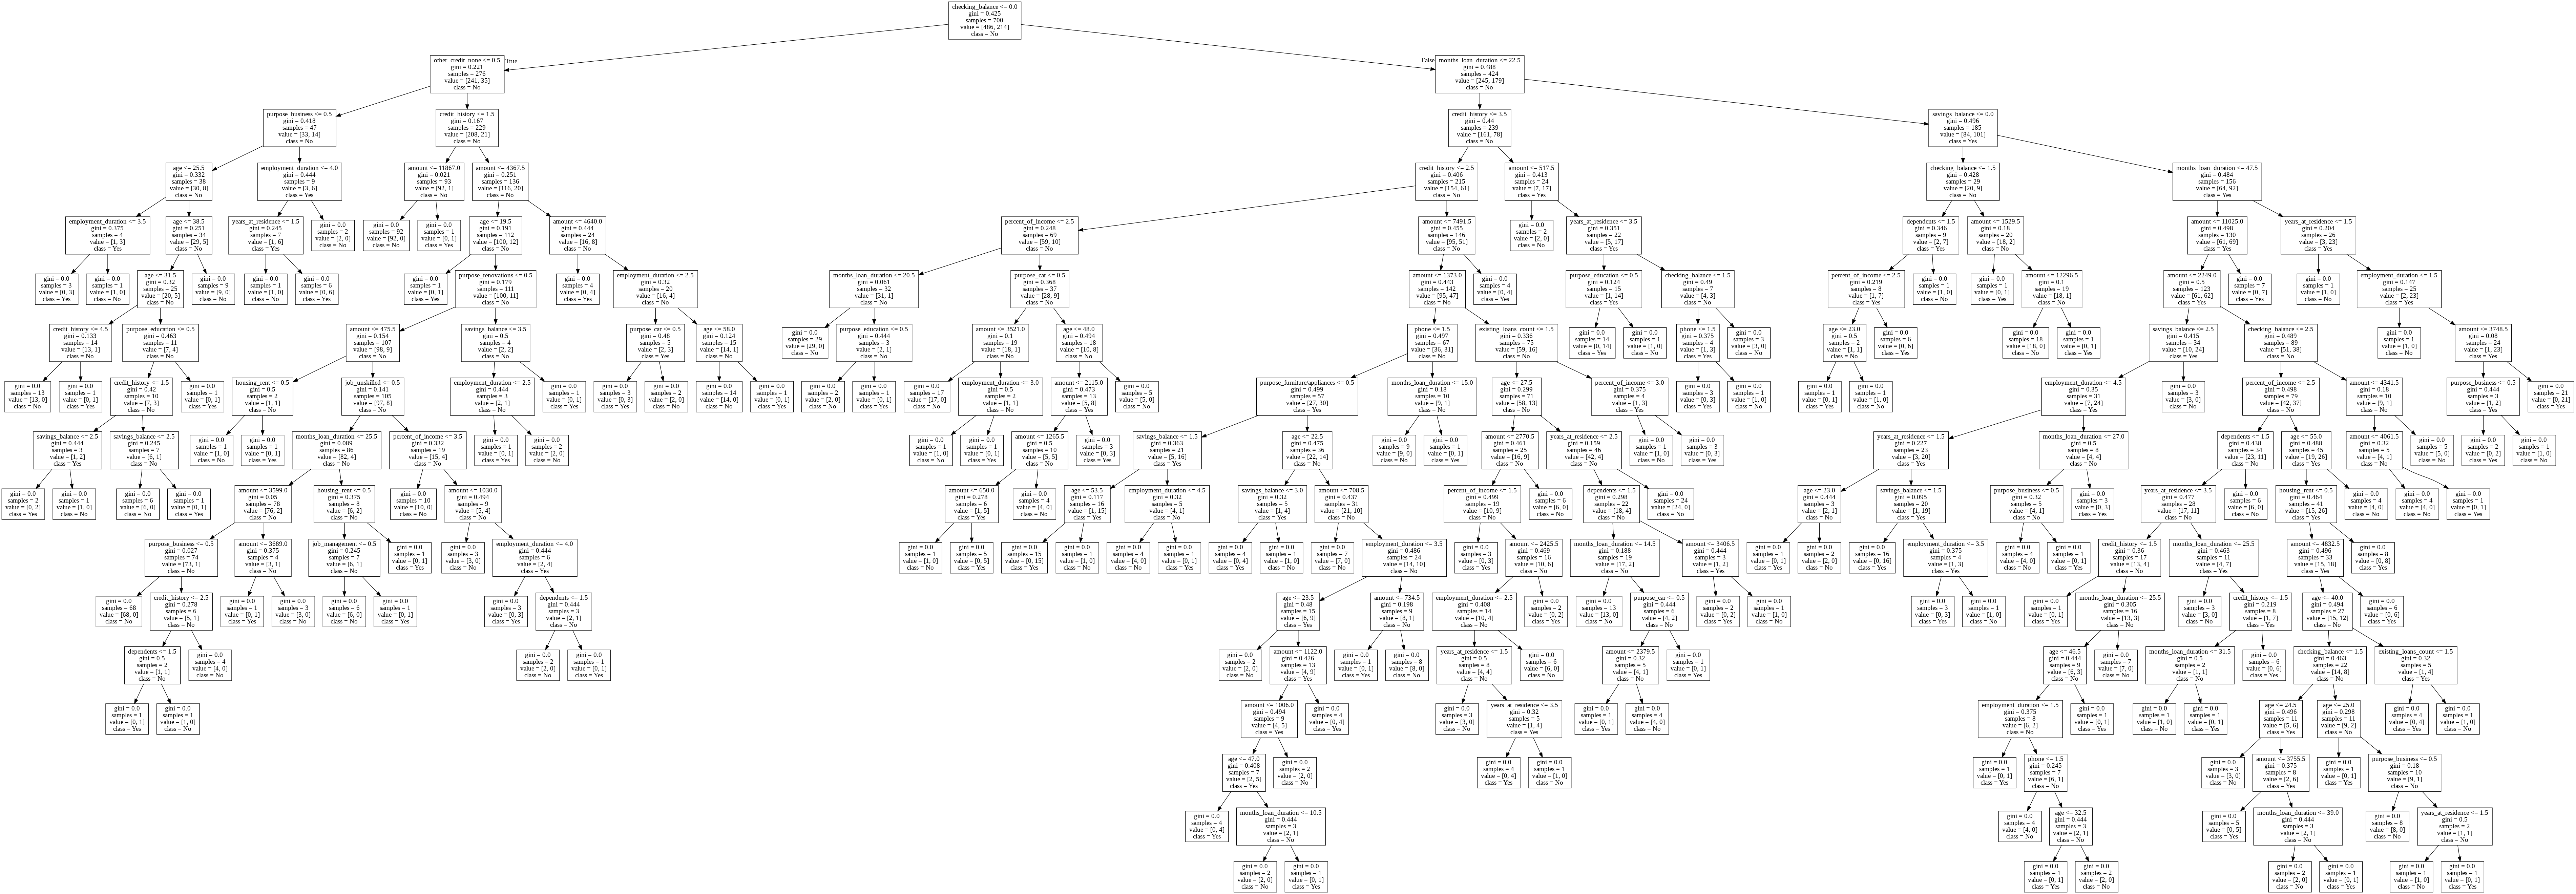

In [24]:
#Works only if "dot" command works on you machine

retCode = system("dot -Tpng credit_tree.dot -o credit_tree.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("credit_tree.png"))

    

## Reducing over fitting (Regularization)

In [25]:
dTreeR = DecisionTreeClassifier(criterion = 'gini', max_depth = 3, random_state=1)
dTreeR.fit(X_train, y_train)
print(dTreeR.score(X_train, y_train))
print(dTreeR.score(X_test, y_test))

0.7528571428571429
0.7433333333333333


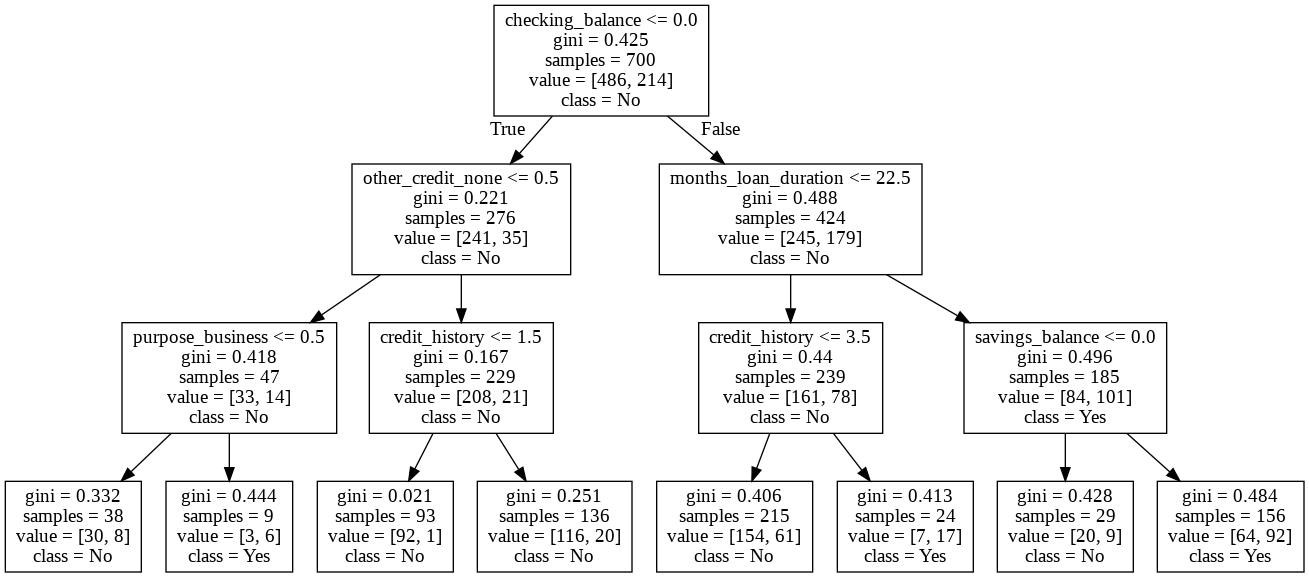

In [26]:
train_char_label = ['No', 'Yes']
Credit_Tree_FileR = open('credit_treeR.dot','w')
dot_data = tree.export_graphviz(dTreeR, out_file=Credit_Tree_FileR, feature_names = list(X_train), class_names = list(train_char_label))
Credit_Tree_FileR.close()

#Works only if "dot" command works on you machine

retCode = system("dot -Tpng credit_treeR.dot -o credit_treeR.png")
if(retCode>0):
    print("system command returning error: "+str(retCode))
else:
    display(Image("credit_treeR.png"))



In [27]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print (pd.DataFrame(dTreeR.feature_importances_, columns = ["Imp"], index = X_train.columns))

                                   Imp
checking_balance              0.492510
months_loan_duration          0.169806
credit_history                0.166109
amount                        0.000000
savings_balance               0.064467
employment_duration           0.000000
percent_of_income             0.000000
years_at_residence            0.000000
age                           0.000000
existing_loans_count          0.000000
dependents                    0.000000
phone                         0.000000
purpose_business              0.051129
purpose_car                   0.000000
purpose_car0                  0.000000
purpose_education             0.000000
purpose_furniture/appliances  0.000000
purpose_renovations           0.000000
housing_other                 0.000000
housing_own                   0.000000
housing_rent                  0.000000
other_credit_bank             0.000000
other_credit_none             0.055977
other_credit_store            0.000000
job_management           

0.7433333333333333


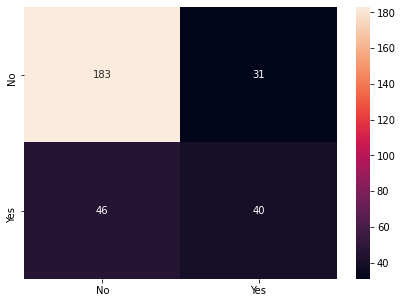

In [28]:
print(dTreeR.score(X_test , y_test))
y_predict = dTreeR.predict(X_test)

cm=metrics.confusion_matrix(y_test, y_predict, labels=[0, 1])

df_cm = pd.DataFrame(cm, index = [i for i in ["No","Yes"]],
                  columns = [i for i in ["No","Yes"]])
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, annot=True ,fmt='g')
